

---



---



---



**Загрузка данных**

In [ ]:
from skimage.segmentation import felzenszwalb
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kostyasereginmailru","key":"ad05ad97cdde449caa2e57874c5b2819"}'}

In [ ]:
%%capture
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection/

 56% 16.0M/28.4M [00:00<00:00, 80.3MB/s]
100% 28.4M/28.4M [00:00<00:00, 117MB/s] 


In [ ]:
!unzip -qq /content/fruit-images-for-object-detection.zip



---



---



---



In [ ]:
!pip install -q torch_snippets lovely-tensors torchinfo

from torch_snippets import *
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
display.set_matplotlib_formats('svg')

from torchinfo import summary

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<ipython-input-6-1daa5d9ef347>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')




---



---



---



# **Используем для разбивки по папкам train, test, split**

In [ ]:
%%capture
!python -m venv env #создает отдельную среду для работы над разными проектами
!pip install split-folders # разбивает данные по папкам train, val, test
!pip install colorama

In [ ]:
import os
import shutil
import splitfolders
import pandas as pd
import numpy as np
from tqdm import tqdm
from colorama import Fore

In [ ]:
IMAGE_PATH = "/content/images/images" # The path to the folder with images.
TARGET_PATH = "/content/annotation/annotation/YOLO-format" # The path to the folder with the annotation (labels).

**create_dataset() - создает фрейм данных со столбцами путей к файлам с аннотациями и изображениями**

In [ ]:
def create_dataset(data_path: str, target_path: str) -> pd.DataFrame:
    assert isinstance(data_path, str)
    assert isinstance(target_path, str)

    dict_paths = {
        "image": [],
        "annotation": []
    }

    for dir_name, _, filenames in os.walk(data_path):
        for filename in filenames:
            name = filename.split('.')[0]
            dict_paths["image"].append(f"{data_path}/{name}.jpg")
            dict_paths["annotation"].append(f"{target_path}/{name}.txt")


    dataframe = pd.DataFrame(
        data=dict_paths,
        index=np.arange(0, len(dict_paths["image"]))
    )

    return dataframe

**prepare_dirs() - создает папки, в которые будут извлечены файлы с изображениями и их аннотациями в формате YOLO**

In [ ]:
def prepare_dirs(dataset_path: str,
                 annotation_path: str,
                 images_path: str) -> None:
    if not os.path.exists(dataset_path):
        os.mkdir(path=dataset_path)
        os.mkdir(path=annotation_path)
        os.mkdir(path=images_path)

**copy_dirs() - копирует файлы файлы с изображениями и их привязкой в формате YOLO в отдельные папки**

In [ ]:
def copy_dirs(dataframe: pd.DataFrame,
             data_path: str,
             target_path: str) -> None:

    assert isinstance(dataframe, pd.DataFrame)
    assert isinstance(data_path, str)
    assert isinstance(target_path, str)

    for i in tqdm(range(len(dataframe))):
        image_path, annotation_path = dataframe.iloc[i]
        shutil.copy(image_path, data_path)
        shutil.copy(annotation_path, target_path)

**finalizing_preparation() - Завершает обработку данных. Проверяет целостность набора данных. Удаляет мусор после предварительной обработки**

In [ ]:
def finalizing_preparation(dataset_path: str, ladd_path: str):
    assert os.path.exists(f"{dataset_path}")

    example_structure = [
        "dataset",
        "train", "labels", "images",
        "test","labels", "images",
        "val", "labels", "images"
    ]

    dir_bone = (
        dirname.split("/")[-1]
        for dirname, _, filenames in os.walk('/content/working/dataset')
        if dirname.split("/")[-1] in example_structure
    )

    try:
        print("\n~ Lacmus Dataset Structure ~\n")
        print(
        f"""
      ├── {next(dir_bone)}
      │   │
      │   ├── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │
      │   ├── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │
      │   ├── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
        """
        )
    except StopIteration as e:
        print(e)
    else:
        print(Fore.GREEN + "-> Success")
    finally:
        os.system(f"rm -rf {ladd_path}")



---



---



---



### **Компануем данные**

**Создайте фрейм данных со столбцами "изображение" и "аннотация", в них будут храниться пути к файлам с изображениями и их аннотациями.**

In [ ]:
df = create_dataset(
    data_path=IMAGE_PATH,
    target_path=TARGET_PATH
)
df.shape
df.head(2)

,image,annotation
0,/content/images/images/978.jpg,/content/annotation/annotation/YOLO-format/978...
1,/content/images/images/218.jpg,/content/annotation/annotation/YOLO-format/218...


In [ ]:
# Примечание: папку working нужно создать вручную, иначе ошибка
dataset_path = "/content/working/dataset"
ladd_path = "/content/working/ladd"
annotation_path = "/content/working/ladd/labels"
image_path = "/content/working/ladd/images"

**Создаем папки, в которые мы извлекаем аннотации в формате YOLO и изображения**

In [ ]:
os.mkdir('working')
prepare_dirs(
    dataset_path=ladd_path,
    annotation_path=annotation_path,
    images_path=image_path
)

**Скопируйте файлы с картинками и аннотациями к ним в эти папки**

In [ ]:
copy_dirs(
    dataframe=df,
    data_path=image_path,
    target_path=annotation_path
)

100%|██████████| 1365/1365 [01:08<00:00, 19.95it/s]


**Используйте библиотеку, чтобы разделить набор данных на обучающие, тестовые и проверочные выборки. Этот формат не просто удобен, но и необходим для работы с фреймворком ultralytics**

In [ ]:
splitfolders.ratio(
    input=ladd_path,
    output=dataset_path,
    seed=42,
    ratio=(0.80, 0.10, 0.10),
    group_prefix=None,
    move=True
)

Copying files: 2730 files [00:00, 18708.97 files/s]


**Завершите предварительную обработку. Проверьте, как прошли процессы**

In [ ]:
finalizing_preparation(
    dataset_path,
    ladd_path
)

~ Lacmus Dataset Structure ~

├── dataset
      │   │
      │   ├── test
      │   │   └── labels
      │   │   └── images
      │   │        
      │   ├── train
      │   │   └── labels
      │   │   └── images
      │   │
      │   ├── val
      │   │   └── labels
      │   │   └── images

[32m-> Success

# **Подготовка данных завершена**



---



---



---



---



---



извлеките изображения
измените их
размер извлеките метки объектов для каждого изображения
извлеките основные границы объектов для каждого изображения
измените их размер соответствующим образом

In [ ]:
root = '/content/train_zip/train/'

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [ ]:
num_classes

4

In [ ]:
targets2label

{0: 'background', 1: 'orange', 2: 'apple', 3: 'banana'}

In [ ]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target:
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)
    plt.show()

tensor([ 24.,  58., 183., 203.])

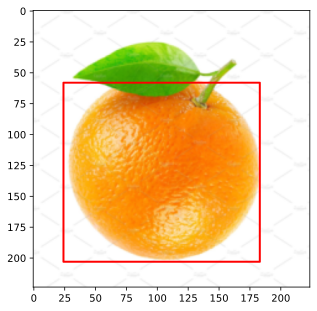

In [ ]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        #----------------------
        # достаем факт размер картинки (почему-то 2 канала)
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        #----------------------
        # достаем картинку, меняем размер (появляются 3-й канала)
        img = np.array(img.resize((w, h),
                       resample=Image.Resampling.BILINEAR))/255.
        #----------------------
        # достаем коробки, метки и компануем в словарь
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        #----------------------
        # преобразуем картинку согласно функции preprocess_img
        img = preprocess_img(img)
        #----------------------
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

train_root = '/content/test_zip/test/'
val_root = '/content/test_zip/test/'

train_ds = FruitsDataset(root=train_root)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn, drop_last=True)

img, target = train_ds[59]
plot_img_bbox(img.permute(1,2,0), target['boxes'])

In [ ]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# test the model
imgs, targets = next(iter(train_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
print(model(imgs, targets))
summary(model, (1,3,224,224))




---



---



---



# **Заморозки/разморозки модели**

In [ ]:
model # модель

In [ ]:
# замораживаем все слои
for param in model.parameters():
  param.requires_grad = False

In [ ]:
# размораживаем выбранные слои
unfreeze_layers = [model.backbone.body.layer4, model.backbone.fpn, model.roi_heads, model.rpn.head]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:
# глядим замороженные/размороженные слои
for name, param in model.named_parameters():
    print(name,param.requires_grad)



---



---



---



In [ ]:
read('/content/frukty-yagody-vinograd-kivi.jpg').shape

(3648, 5472)

In [ ]:
for i in train_ds:
  print(i)
  break

(
    tensor([[[0.8039, 0.8235, 0.7804,  ..., 0.5451, 0.8235, 0.8510],
         [0.7725, 0.8000, 0.8078,  ..., 0.4157, 0.7059, 0.8039],
         [0.7373, 0.7765, 0.8196,  ..., 0.2980, 0.5843, 0.7725],
         ...,
         [0.3451, 0.5529, 0.5569,  ..., 0.1137, 0.1882, 0.3216],
         [0.3451, 0.4745, 0.4588,  ..., 0.0510, 0.1373, 0.3294],
         [0.3373, 0.4078, 0.3765,  ..., 0.0549, 0.1569, 0.3294]],

        [[0.9059, 0.9255, 0.8824,  ..., 0.5961, 0.8549, 0.8667],
         [0.8627, 0.8941, 0.9020,  ..., 0.4784, 0.7529, 0.8314],
         [0.8275, 0.8667, 0.9137,  ..., 0.3686, 0.6392, 0.8157],
         ...,
         [0.3843, 0.5843, 0.5765,  ..., 0.1804, 0.2627, 0.3961],
         [0.3961, 0.5176, 0.4980,  ..., 0.1725, 0.2627, 0.4471],
         [0.3922, 0.4549, 0.4275,  ..., 0.2039, 0.3098, 0.4784]],

        [[0.9020, 0.9255, 0.8745,  ..., 0.3294, 0.5647, 0.5608],
         [0.8745, 0.9020, 0.9020,  ..., 0.2314, 0.4824, 0.5294],
         [0.8471, 0.8902, 0.9255,  ..., 0.1529, 0.3882, 0.5216],
         ...,
         [0.2275, 0.3608, 0.3255,  ..., 0.0275, 0.0667, 0.1725],
         [0.2471, 0.3137, 0.2745,  ..., 0.0431, 0.0941, 0.2431],
         [0.2431, 0.2627, 0.2275,  ..., 0.0824, 0.1529, 0.2824]]]),
    {
        'labels': tensor([2, 2, 2, 2, 2]),
        'boxes': tensor([[ 53.,  58., 130., 160.],
        [  8.,  21.,  78., 108.],
        [100.,  22., 181., 112.],
        [ 79., 123., 161., 224.],
        [154., 134., 222., 224.]])
    }
)



---



---



---



In [ ]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

n_epochs = 20
log = Report(n_epochs)
for e in range(n_epochs):
    for i, batch in enumerate(train_dl):
        N = len(train_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
    log.report_avgs(e+1)
log.plot_epochs(['trn_loss', 'val_loss'])

# **Тестируем модель**

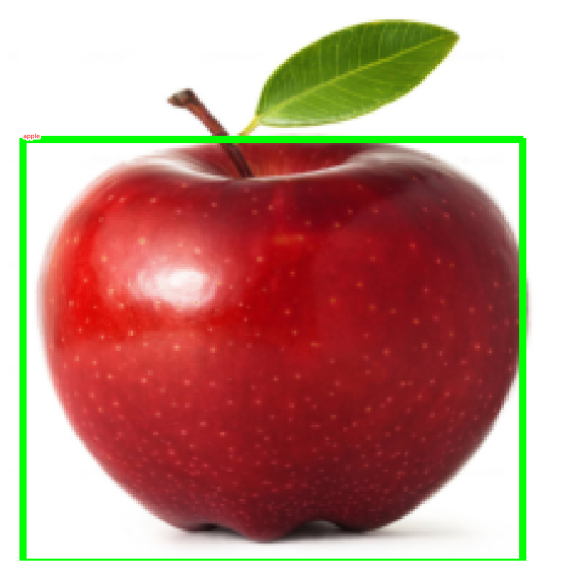

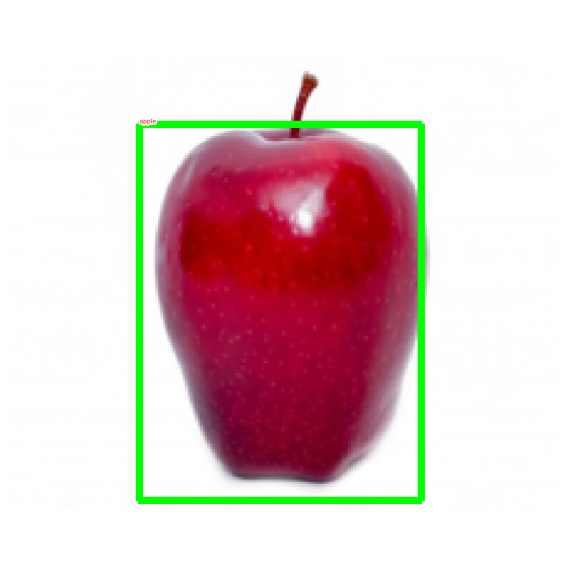

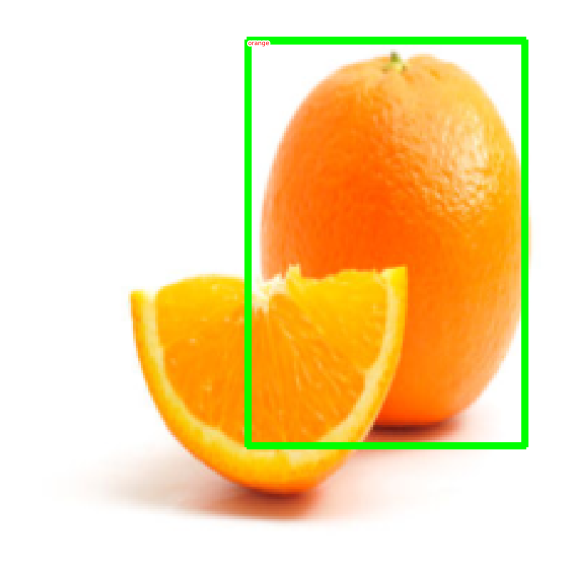

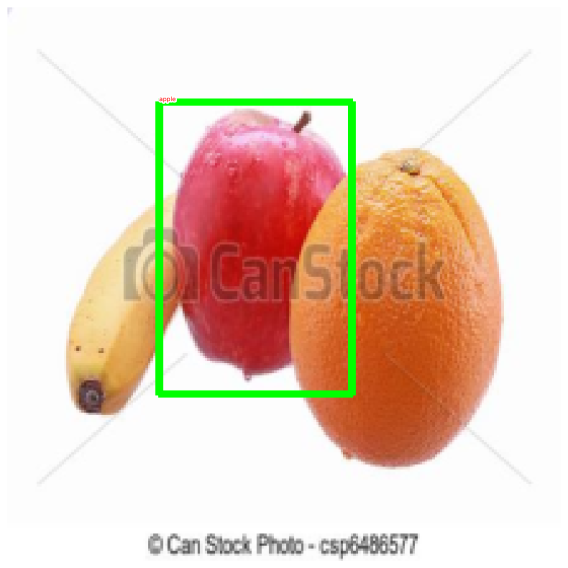

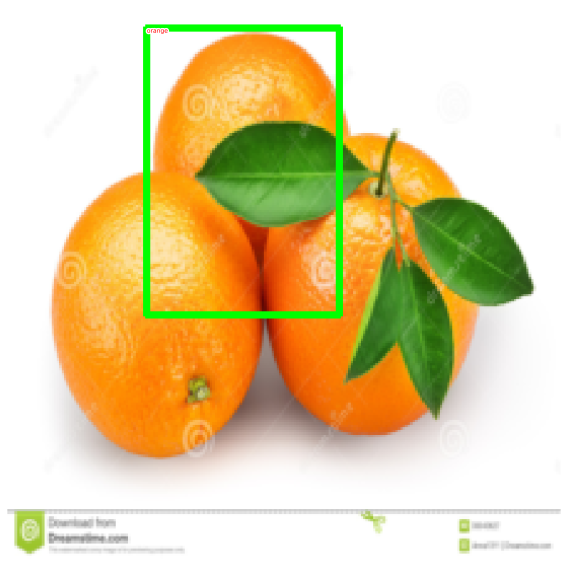

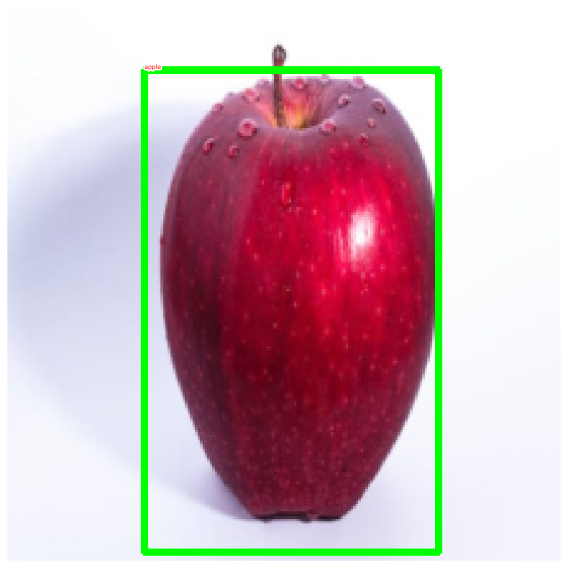

In [ ]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    imgs = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    if i == 3: break
    images = [im for im in imgs]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
#        plot_img_bbox(images[i].cpu().permute(1,2,0), bbs)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=10)



---



---



---



---



---



# **Предварительная обработка левой картинки**

In [ ]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.float()
def img_for_prediction(way):
    w, h = 224, 224
    img_path = way
    img = Image.open(img_path).convert('RGB')
#    W, H = img.size
    img = np.array(img.resize((w, h),
                    resample=Image.Resampling.BILINEAR))/255.
    img = preprocess_img(img)
    #----------------------
    return img

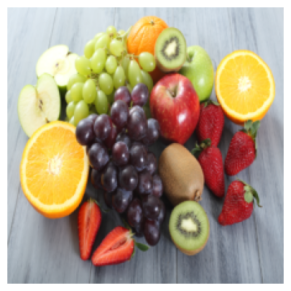

In [ ]:
o = img_for_prediction('/content/frukty-yagody-vinograd-kivi.jpg')
show(o)